In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier
from xgboost import plot_tree, plot_importance
from sklearn.datasets import load_iris

# Set plot style
plt.style.use('ggplot')
sns.set_theme(font_scale=1.2)

# For reproducibility
np.random.seed(42)

In [2]:
# Load the project dataset
from prep import preprocess_data

train_df = pd.read_csv('./apache/train_labeled.csv')
test_df = pd.read_csv('./apache/test_labeled.csv')

train_df = preprocess_data(train_df, compact=True)
test_df = preprocess_data(test_df, compact=True)

# check if the columns are the same
if set(train_df.columns) != set(test_df.columns):
    print("Warning: Train and test datasets have different columns.")
    # Print the differences
    train_columns = set(train_df.columns)
    test_columns = set(test_df.columns)
    # get the columns that are in train but not in test
    train_only = train_columns - test_columns
    # get the columns that are in test but not in train
    test_only = test_columns - train_columns
    if train_only:
        print(f"Columns in train but not in test: {train_only}")
    if test_only:
        print(f"Columns in test but not in train: {test_only}")

In [3]:
# Encode 'project_category' using data from train_df
oe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_encoded = oe.fit_transform(train_df[['project_category']])
test_encoded = oe.transform(test_df[['project_category']])
# Create DataFrames for the encoded categories
train_encoded_df = pd.DataFrame(train_encoded, columns=oe.get_feature_names_out(['project_category']))
test_encoded_df = pd.DataFrame(test_encoded, columns=oe.get_feature_names_out(['project_category']))
# Concatenate the encoded DataFrames with the original DataFrames
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

In [4]:
# useful columns derived from feature engineering
top_risk_predictors = pd.read_csv('./apache/top_risk_predictors.csv')
schedule_features = top_risk_predictors['Schedule Risk Predictors'].tolist()
quality_features = top_risk_predictors['Quality Risk Predictors'].tolist()

# Filter the DataFrame to keep only the top predictors (plus 'project_category' and the target variable)
schedule_train_df = train_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_train_df = train_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

schedule_test_df = test_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_test_df = test_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

In [5]:
target = 'schedule_risk'
# target = 'quality_risk'
target_names = ['Low Risk', 'High Risk']

if target == 'schedule_risk':
    train_df = schedule_train_df
    test_df = schedule_test_df
    features = schedule_features
elif target == 'quality_risk':
    train_df = quality_train_df
    test_df = quality_test_df
    features = quality_features

In [6]:
# Prepare data for modeling
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

In [7]:
# 5. Model Training - Baseline XGBoost Model

# Create a baseline XGBoost model (binary classification)
baseline_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),  # Handle class imbalance
)

# Fit the model to the training data
baseline_xgb.fit(X_train, y_train)

# Make predictions on test data
y_pred_baseline = baseline_xgb.predict(X_test)

# Evaluate baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline XGBoost Accuracy: {baseline_accuracy:.4f}")

# Display classification report
print("\nClassification Report (Baseline Model):")
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

Baseline XGBoost Accuracy: 0.8790

Classification Report (Baseline Model):
              precision    recall  f1-score   support

    Low Risk       0.92      0.91      0.92        93
   High Risk       0.75      0.77      0.76        31

    accuracy                           0.88       124
   macro avg       0.84      0.84      0.84       124
weighted avg       0.88      0.88      0.88       124



In [8]:
# 6. Cross-validation

# Perform k-fold cross-validation on the baseline model
n_folds = 5
cv_scores = cross_val_score(baseline_xgb, X_train, y_train, cv=n_folds, scoring='accuracy')

print(f"\nCross-validation scores (k={n_folds}): {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation scores (k=5): [0.91919192 0.87878788 0.89795918 0.89795918 0.89795918]
Mean CV accuracy: 0.8984 ± 0.0128


In [9]:
# 7. Hyperparameter Tuning

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Create an XGBoost classifier
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),  # Handle class imbalance
)

# Perform grid search with cross-validation
print("Performing grid search for hyperparameter tuning (this may take some time)...")
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_xgb = grid_search.best_estimator_

Performing grid search for hyperparameter tuning (this may take some time)...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation score: 0.8964



Best XGBoost Test Accuracy: 0.8952
Improvement over baseline: 1.61%

Classification Report (Best Model):
              precision    recall  f1-score   support

    Low Risk       0.93      0.94      0.93        93
   High Risk       0.80      0.77      0.79        31

    accuracy                           0.90       124
   macro avg       0.86      0.85      0.86       124
weighted avg       0.89      0.90      0.89       124



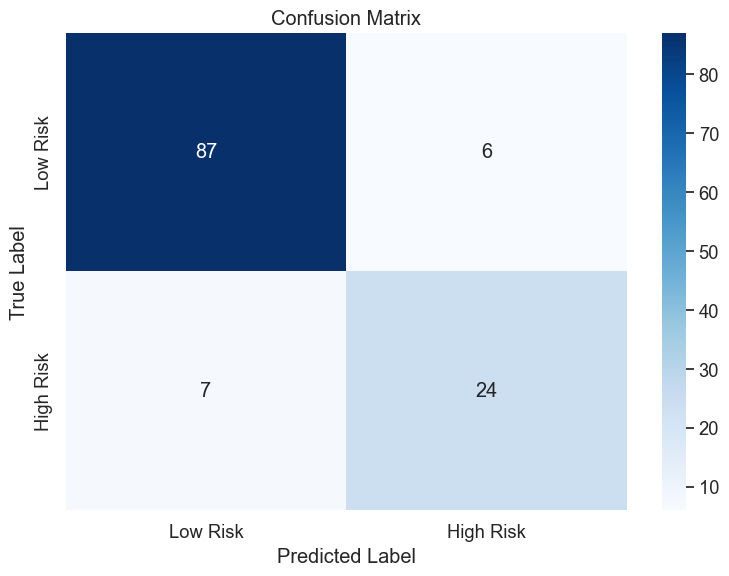

In [10]:
# 8. Model Evaluation with Best Model

# Make predictions on the test set using the best model
y_pred = best_xgb.predict(X_test)

# Calculate accuracy
best_accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest XGBoost Test Accuracy: {best_accuracy:.4f}")

# Calculate if there was an improvement over baseline
improvement = (best_accuracy - baseline_accuracy) * 100
print(f"Improvement over baseline: {improvement:.2f}%")

# Display classification report for the best model
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred, target_names=target_names))

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [11]:
# Get probability predictions
y_proba = best_xgb.predict_proba(X_test)

# Display probability predictions for the first few samples
prob_df = pd.DataFrame(y_proba, columns=target_names)
prob_df['True Class'] = [target_names[i] for i in y_test]
prob_df['Predicted Class'] = [target_names[i] for i in y_pred]
print("\nProbability predictions for the first 5 test samples:")
print(prob_df.head())


Probability predictions for the first 5 test samples:
   Low Risk  High Risk True Class Predicted Class
0  0.998890   0.001110   Low Risk        Low Risk
1  0.599172   0.400828   Low Risk        Low Risk
2  0.997039   0.002961   Low Risk        Low Risk
3  0.934305   0.065695  High Risk        Low Risk
4  0.997107   0.002893   Low Risk        Low Risk



Feature Importance:
                                              Feature  Importance
0                            num_resolution_fixed_pct    0.292296
3                        num_resolution_won't_fix_pct    0.125979
14                                   resolution_ratio    0.098077
6                                     total_reporters    0.092925
16  project_category_Build, Release, & Project Man...    0.035872
1                                     total_assignees    0.033492
8                                    average_workspan    0.032287
4                     average_fix_version_change_rate    0.030592
23  project_category_Incubator & Retired/Dormant P...    0.030432
11                                   average_lifespan    0.029789
2                                       total_changes    0.028540
31          project_category_Web Services & Messaging    0.027156
5                                        total_issues    0.025040
9                              average_change_density  

C:\Users\phuon\AppData\Local\Temp\ipykernel_3044\2912219757.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


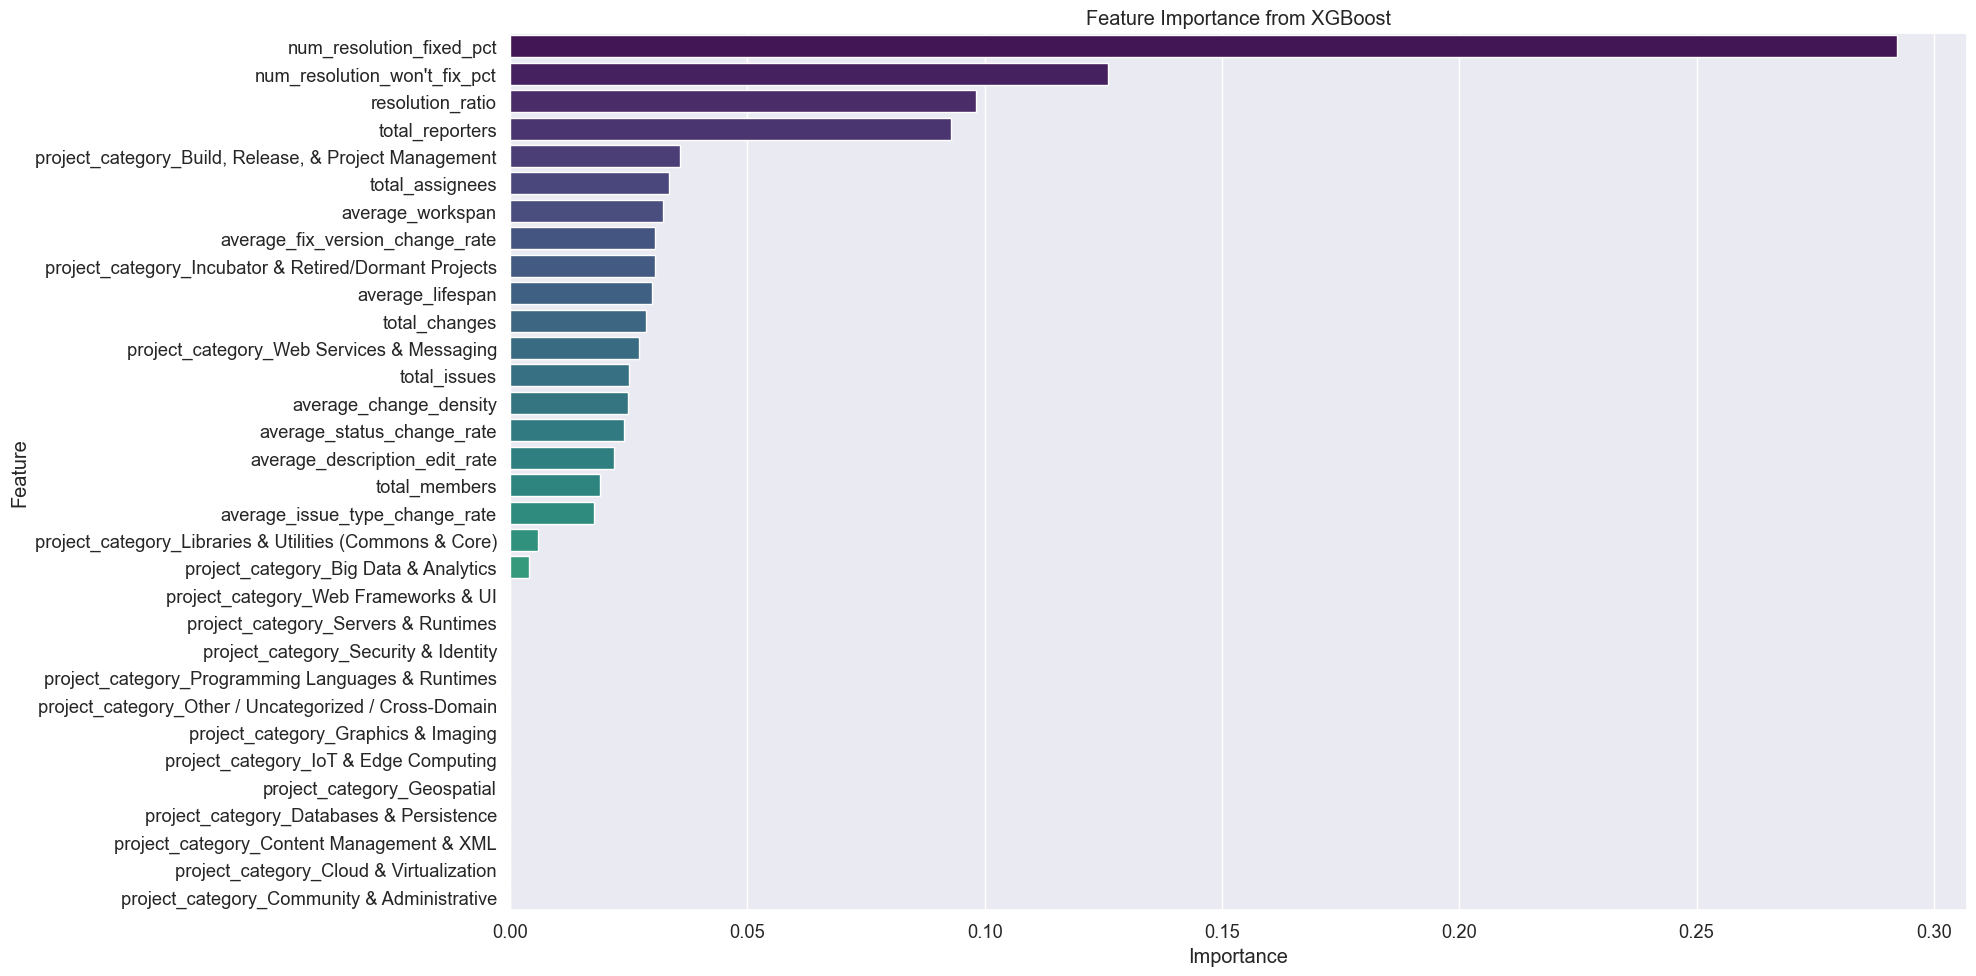

In [12]:
# 9. Feature Importance Analysis

# Get feature importances from the best model
importances = best_xgb.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# # Visualize feature importances using XGBoost's built-in function
# plt.figure(figsize=(10, 6))
# plot_importance(best_xgb)
# plt.title('Feature Importance from XGBoost')
# plt.tight_layout()
# plt.show()

# Alternative visualization using seaborn
plt.figure(figsize=(20, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from XGBoost')
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

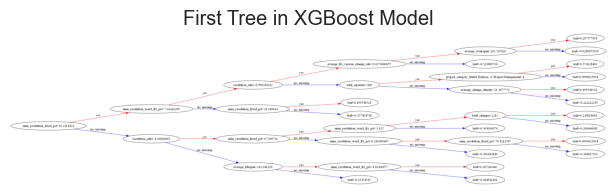

In [13]:
# 10. Tree Visualization

# Visualize one of the trees in the XGBoost model
plt.figure(figsize=(15, 10))
plot_tree(best_xgb, num_trees=0, rankdir='LR')
plt.title('First Tree in XGBoost Model')
plt.tight_layout()
plt.show()

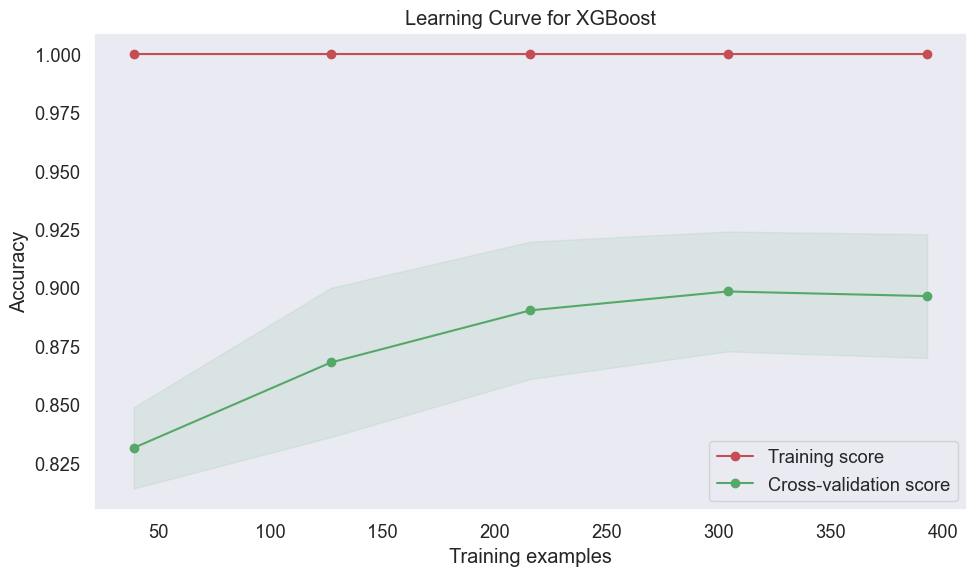

In [14]:
# 11. Learning Curve Analysis

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring="accuracy")
    
    # Calculate mean and std
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.tight_layout()
    return plt

# Plot learning curve for the best XGBoost model
plot_learning_curve(best_xgb, X_train, y_train, 
                  title="Learning Curve for XGBoost")
plt.show()

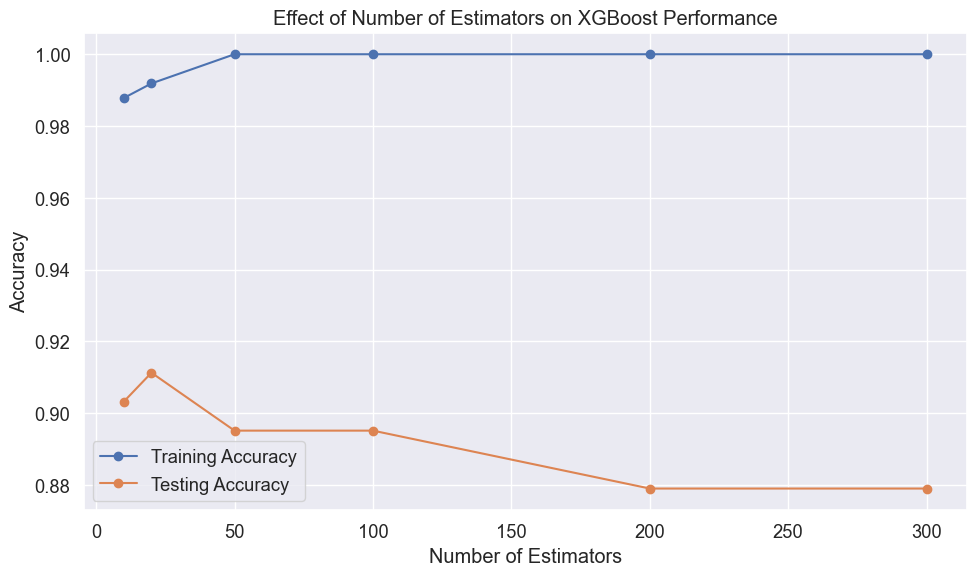

In [15]:
# 12. Hyperparameter Influence Analysis

# Analyze the effect of the number of estimators on model performance
n_estimators_list = [10, 20, 50, 100, 200, 300]
accuracies_train = []
accuracies_test = []

# Get the best parameters except n_estimators
best_params = best_xgb.get_params()

for n_estimators in n_estimators_list:
    # Create and train model with current n_estimators value
    params = {k: v for k, v in best_params.items() if k != 'n_estimators'}
    model = XGBClassifier(n_estimators=n_estimators, **params)
    model.fit(X_train, y_train)
    
    # Calculate and store accuracy scores
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    accuracies_train.append(train_accuracy)
    accuracies_test.append(test_accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, accuracies_train, 'o-', label='Training Accuracy')
plt.plot(n_estimators_list, accuracies_test, 'o-', label='Testing Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Effect of Number of Estimators on XGBoost Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

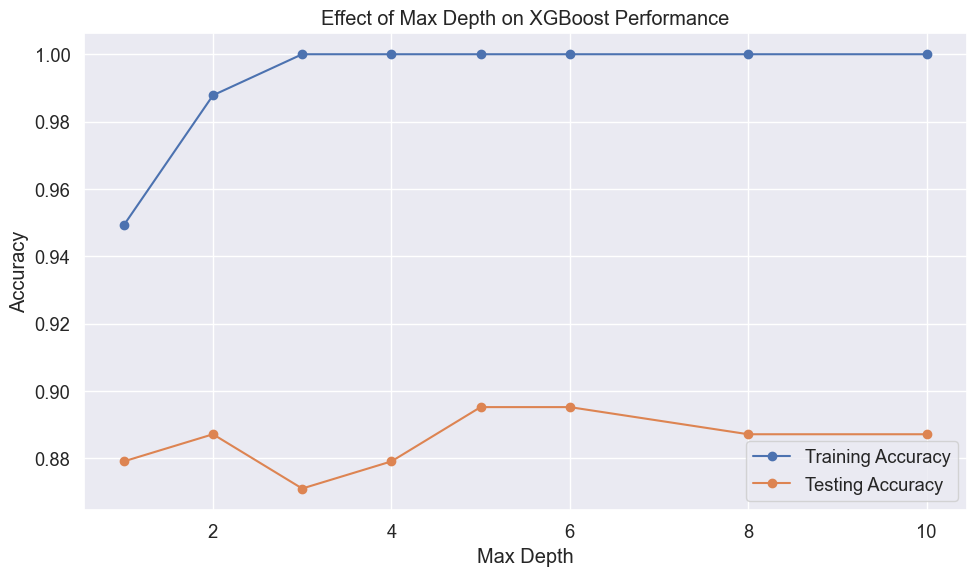

In [16]:
# Analyze the effect of max_depth on model performance
max_depth_list = [1, 2, 3, 4, 5, 6, 8, 10]
md_accuracies_train = []
md_accuracies_test = []

# Get the best parameters except max_depth
best_params = best_xgb.get_params()

for max_depth in max_depth_list:
    # Create and train model with current max_depth value
    params = {k: v for k, v in best_params.items() if k != 'max_depth'}
    model = XGBClassifier(max_depth=max_depth, **params)
    model.fit(X_train, y_train)
    
    # Calculate and store accuracy scores
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    md_accuracies_train.append(train_accuracy)
    md_accuracies_test.append(test_accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, md_accuracies_train, 'o-', label='Training Accuracy')
plt.plot(max_depth_list, md_accuracies_test, 'o-', label='Testing Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Effect of Max Depth on XGBoost Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

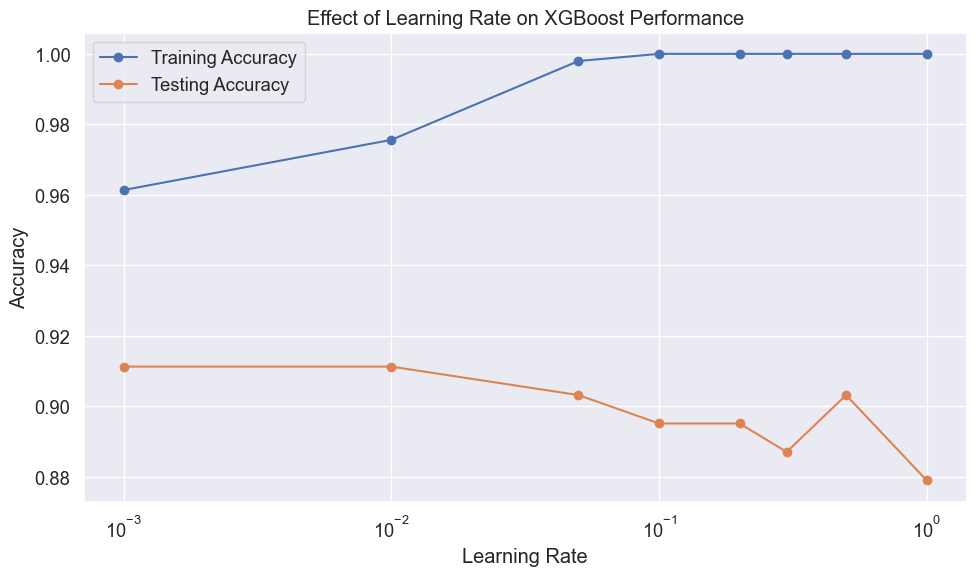

In [17]:
# Analyze the effect of learning rate on model performance
learning_rate_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
lr_accuracies_train = []
lr_accuracies_test = []

# Get the best parameters except learning_rate
best_params = best_xgb.get_params()

for learning_rate in learning_rate_list:
    # Create and train model with current learning_rate value
    params = {k: v for k, v in best_params.items() if k != 'learning_rate'}
    model = XGBClassifier(learning_rate=learning_rate, **params)
    model.fit(X_train, y_train)
    
    # Calculate and store accuracy scores
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    lr_accuracies_train.append(train_accuracy)
    lr_accuracies_test.append(test_accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogx(learning_rate_list, lr_accuracies_train, 'o-', label='Training Accuracy')
plt.semilogx(learning_rate_list, lr_accuracies_test, 'o-', label='Testing Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Effect of Learning Rate on XGBoost Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# 14. Model Persistence

import joblib
import os

# Create directory for models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the best model
model_filename = 'models/schedule_risk_xgboost_model.joblib'
joblib.dump(best_xgb, model_filename)
print(f"\nModel saved to {model_filename}")

# Example of how to load the model
loaded_model = joblib.load(model_filename)

# Test the loaded model
predictions = loaded_model.predict(X_test)

print(f"Loaded model accuracy on test set: {accuracy_score(y_test, predictions):.4f}")


Model saved to models/schedule_risk_xgboost_model.joblib
Loaded model accuracy on test set: 0.8952
